# Step 3 - Climate Analysis and Exploration

In [1]:
# Dependencies
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [ ]:
# Choose a start date and end date for your trip. Make sure that your vacation range is approximately 3-15 days total.

In [2]:
# Use SQLAlchemy create_engine to connect to your sqlite database.
engine = create_engine("sqlite:///hawaii.sqlite", echo=False)

In [3]:
inspector = inspect(engine)
inspector.get_table_names()

['measurements', 'stations']

In [4]:
# Get a list of column names and types
ms_columns = inspector.get_columns('measurements')
for c in ms_columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station VARCHAR
date VARCHAR
prcp FLOAT
tobs INTEGER


In [5]:
st_columns = inspector.get_columns('stations')
for c in st_columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station VARCHAR
name VARCHAR
latitude FLOAT
longtitude FLOAT
elevation FLOAT


In [6]:
# Use SQLAlchemy automap_base() to reflect your tables into classes and save a reference to those classes called Station and Measurement.
Base = automap_base()
Base.prepare(engine, reflect=True)
Mea = Base.classes.measurements
Sta = Base.classes.stations

In [7]:
session = Session(engine)

In [8]:
session.query(func.count(Mea.date)).all()

[(18103)]

In [9]:
session.query(func.count(Sta.name)).all()

[(9)]

## Precipitation Analysis

In [12]:
import datetime as dt
import pandas as pd
from dateutil.relativedelta import relativedelta

# Get a year ago date using dateutil.relativedelta
yearAgo_date = dt.date.today() + relativedelta(months=-12)

# Design a query to retrieve the last 12 months of precipitation data
# Select only the date and prcp values
# Load the query results into a Pandas DataFrame
prcp=pd.read_sql(session.query(Mea.date, Mea.prcp).filter(Mea.date > yearAgo_date, Mea.date < dt.date.today()).order_by(Mea.date).statement, session.bind)
# prcp

In [13]:
# set date as datetime
prcp['date']=pd.to_datetime(prcp['date'])
type(prcp.loc[0,'date'])

pandas._libs.tslib.Timestamp

/Users/tokunaga/.pyenv/versions/anaconda3-5.0.0/envs/PythonData/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


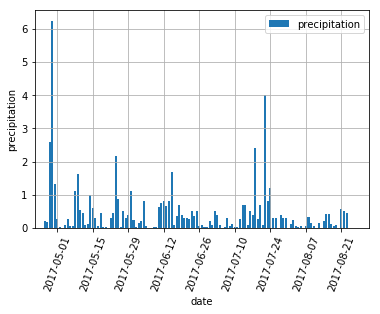

In [17]:
import matplotlib.pyplot as plt

# set the index to the date column.
prcp_i = prcp.set_index('date')

%matplotlib inline
p1 = plt.bar(prcp_i.index, prcp_i['prcp'])
# p1 = plt.scatter(prcp_i.index, prcp_i['prcp'])
plt.xticks(rotation=70)
plt.legend([p1],['precipitation'])

ax=plt.subplot()
ax.set_xlabel('date')
ax.set_ylabel('precipitation')

ax.grid()
ax.set_xlim(['2017-04-22','2017-09-01'])

plt.show()

In [67]:
# prcp.plot.bar()

In [24]:
# Use Pandas to print the summary statistics for the precipitation data.
prcp.describe()
# prcp.describe().loc[prcp.describe().index=='min']['prcp']

,prcp
count,631.000000
mean,0.149287
std,0.404491
min,0.000000
25%,0.000000
50%,0.020000
75%,0.120000
max,6.250000


## Station Analysis

In [19]:
# Design a query to calculate the total number of stations.
session.query(func.count(Sta.name)).all()

[(9)]

In [20]:
# Design a query to find the most active stations.
# List the stations and observation counts in descending order
# sel = [Mea.station, Mea.date, Mea.prcp, Mea.tobs, Sta.station, Sta.name, Sta.latitude, Sta.longtitude, Sta.elevation]
sel = [Sta.name, Mea.station, Mea.date, Mea.prcp, Mea.tobs]

st_DF=pd.read_sql(session.query(*sel).filter(Mea.station == Sta.station).order_by(Mea.date).statement, session.bind)
st_DF.groupby('name').count().sort_values(by='station', ascending=False)['station']
# Which station has the highest number of observations?
highestSt = st_DF.groupby('name').count().sort_values(by='station', ascending=False)['station'].index[0]


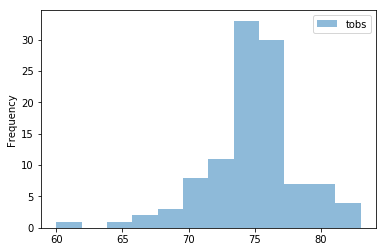

In [21]:
# Design a query to retrieve the last 12 months of temperature observation data (tobs).
yearAgo_date = dt.date.today() + relativedelta(months=-12)
tobs_past12 = pd.read_sql(session.query(Mea.date, Sta.name, Mea.tobs).filter(Mea.station == Sta.station, Mea.date > yearAgo_date, Mea.date < dt.date.today()).order_by(Mea.date).statement, session.bind)
# tobs_past12
# Filter by the station with the highest number of observations.
tobs_past12.loc[tobs_past12['name']== highestSt]

# Plot the results as a histogram with bins=12.
tobs_past12.loc[tobs_past12['name']== highestSt].plot.hist(bins=12, alpha=0.5)

## Temperature Analysis

In [36]:
# Write a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d and return the minimum, average, and maximum temperatures for that range of dates.
def calc_temps(start, end):
#     TODO format check
    tobs_DF = pd.read_sql(session.query(Mea.date, Sta.name, Mea.tobs).filter(Mea.station == Sta.station, Mea.date > start, Mea.date < end).order_by(Mea.date).statement, session.bind)
    return {
        'min': tobs_DF.describe().loc[tobs_DF.describe().index=='min']['tobs'][0],
        'avg': tobs_DF.describe().loc[tobs_DF.describe().index=='mean']['tobs'][0],
        'max': tobs_DF.describe().loc[tobs_DF.describe().index=='max']['tobs'][0]
    }

/Users/tokunaga/.pyenv/versions/anaconda3-5.0.0/envs/PythonData/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


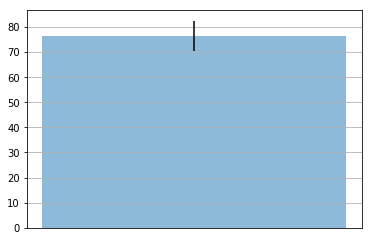

In [52]:
data=calc_temps('2017-05-01', '2017-05-03')
# Use the calc_temps function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e. use "2017-01-01" if your trip start date was "2018-01-01")

# Plot the min, avg, and max temperature from your previous query as a bar chart.
# Use the average temperature as the bar height.
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).
plt.bar(0,data['avg'],yerr=data['max']-data['min'], alpha=0.5)
plt.xticks([1],['avg'])
# ax=plt.subplot()
# ax.set_ylabel('Temp (F)')

ax.grid()
plt.show()
